In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.spatial.distance as distance

from sklearn.metrics import accuracy_score, matthews_corrcoef, recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_validate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


from negativeSelection import (NegativeSelection,  
                                RChunkNSA,
                                signal2string,
                                generate_string,
                                calculate_r_contiguous_matches,
                                calculate_hamming,
                                calculate_rogerstanimoto,
                                match_r_contiguous,
                                match_hamming,
                                match_rogerstanimoto)

SENSOR = "temperature"
WRANGLE_PATH = "../data/wrangle/"

# 1. Importing Dataset

In [2]:
df_train = pd.read_parquet(os.path.join(WRANGLE_PATH, f'{SENSOR}_train_fxd.parquet'))
df_test = pd.read_parquet(os.path.join(WRANGLE_PATH, f'{SENSOR}_test_fxd.parquet'))

Since the model is already trained, and we want to check all the results we can get, we will concatenate train and test for this EDA.

In [3]:
df = pd.concat([df_train, df_test]).reset_index(drop=True)

In [4]:
df.is_property_violation.value_counts()

0    16984
1     3012
Name: is_property_violation, dtype: int64

In [5]:
df.is_property_violation.value_counts(normalize=True)

0    0.84937
1    0.15063
Name: is_property_violation, dtype: float64

In [6]:
df.shape

(19996, 106)

In [7]:
filename = os.path.join(WRANGLE_PATH, f'{SENSOR}_ns_chunk_5_1000_20230612.sav')
# ns = joblib.load(filename)
ns = pickle.load(open(filename, 'rb'))
# nonself_detectors = pd.DataFrame(pickle.load(open(filename, 'rb'))).T.rename(columns={0:"position",1:"chunk"})

In [8]:
ns.nonself_detectors

,position,chunk
0,0,00000
0,1,00000
0,2,00000
0,4,00000
0,5,00000
...,...,...
0,2,01001
0,3,01001
0,4,01001
0,5,01001


In [9]:
sig_cols = ns.features
# sig_cols = [
#     'temperature_was_available_during_transfered',
#     'temperature_transfered',
#     'temperature_was_available_during_centralhub_temperature_processed',
#     'temperature_battery_became_unavailable_during_trace',
#     'temperature_context_became_unavailable_during_trace',
#     'temperature_battery_became_unavailable_during_processed',
#     'temperature_battery_became_unavailable_during_transfered',
#     'temperature_battery_became_unavailable_during_collected',
#     'temperature_processed',
#     'abpd_sig_battery_on_min',
#     'heartrate_sig_battery_on_min',
#     'oximeter_sig_battery_on_min',
#     'abps_sig_battery_on_min',
#     ]


In [10]:
df.filter(sig_cols).T

,0,1,2,3,4,5,6,7,8,9,...,19986,19987,19988,19989,19990,19991,19992,19993,19994,19995
temperature_was_available_during_transfered,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
temperature_transfered,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
temperature_was_available_during_centralhub_temperature_processed,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
temperature_battery_became_unavailable_during_trace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
temperature_context_became_unavailable_during_trace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
temperature_battery_became_unavailable_during_processed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
temperature_battery_became_unavailable_during_transfered,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
temperature_battery_became_unavailable_during_collected,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
temperature_processed,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
abpd_sig_battery_on_min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# 2. Predicting for the entire train and test

In [11]:
y_test = df.is_property_violation
y_pred = ns.predict(df.filter(sig_cols).fillna(0))

In [12]:
y_pred

0        0
1        0
2        0
3        0
4        0
        ..
19991    0
19992    0
19993    0
19994    0
19995    1
Name: self_str, Length: 19996, dtype: int64

<Axes: >

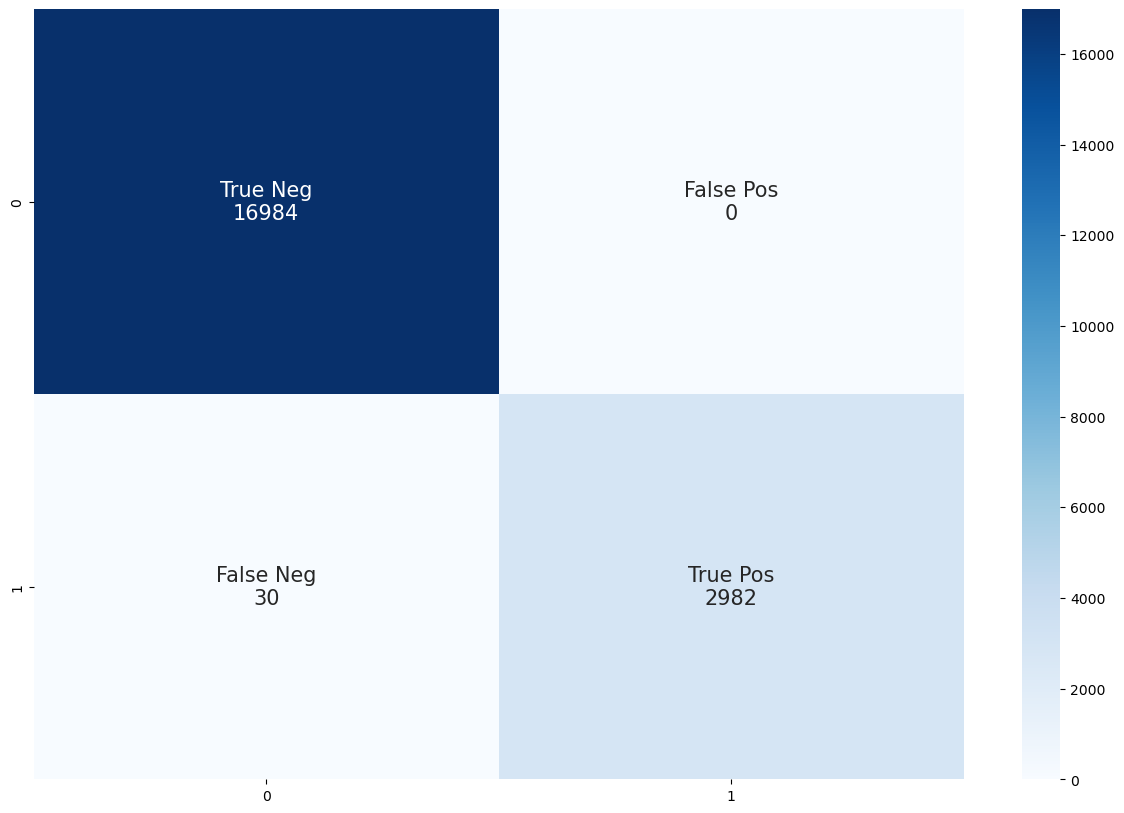

In [13]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [14]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16984
           1       1.00      0.99      0.99      3012

    accuracy                           1.00     19996
   macro avg       1.00      1.00      1.00     19996
weighted avg       1.00      1.00      1.00     19996



In [15]:
recall_score(y_test, y_pred)

0.9900398406374502

In [16]:
precision_score(y_test, y_pred)

1.0

# Findings

In [17]:
# matched = df[(y_test == y_pred) & (y_test == 1)]

In [18]:
df = df.assign(self_str = lambda x: signal2string(x.fillna(0).filter(sig_cols)))

# Generate a list of matches

for each nonself detector see which data it matched

In [19]:
res = pd.DataFrame(columns=ns.nonself_detectors.sort_values('position').values)
for pos, chunk in res.columns:
    res[(pos, chunk)] = df.self_str.str.slice(start=pos, stop=pos + ns.r) == chunk
res

,"(0, 00000)","(0, 01100)","(0, 11010)","(0, 01000)","(0, 00110)","(0, 11011)","(0, 10101)","(0, 01001)","(0, 10111)","(0, 10100)",...,"(7, 10101)","(7, 00110)","(7, 10000)","(7, 11111)","(7, 00011)","(7, 11110)","(7, 10110)","(7, 10011)","(7, 11010)","(7, 00101)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19992,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19993,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19994,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
print("Detectors that matched the most:")
total = res.sum().sum()
match = (res
        .sum()
        .rename('matched')
        .sort_values(ascending=False)
        .to_frame()
        .query('matched > 0')
    )
match

Detectors that matched the most:


,matched
"(1, 00010)",1764
"(0, 00001)",1764
"(0, 00010)",508
"(1, 00101)",272
"(2, 01010)",272
"(4, 01001)",272
"(3, 10100)",272
"(1, 10100)",265
"(2, 01001)",265
"(4, 00101)",265


In [21]:
match.matched

(1, 00010)    1764
(0, 00001)    1764
(0, 00010)     508
(1, 00101)     272
(2, 01010)     272
(4, 01001)     272
(3, 10100)     272
(1, 10100)     265
(2, 01001)     265
(4, 00101)     265
(0, 11010)     265
(3, 10010)     265
(4, 00010)     236
(1, 00100)     236
(2, 01000)     236
(3, 10001)     236
(5, 10010)     211
(2, 00000)     198
(5, 00100)     180
(5, 01010)     175
(0, 00011)     173
(5, 10011)     149
(5, 01011)     144
(5, 00101)     141
(6, 01000)     122
(0, 00000)     115
(1, 00000)     115
(6, 10100)     112
(6, 10111)     107
(7, 10000)      97
(6, 01011)      95
(2, 01110)      88
(1, 00111)      88
(4, 11001)      88
(3, 11100)      88
(2, 01100)      85
(3, 11001)      85
(1, 00110)      85
(4, 10010)      85
(0, 11000)      83
(1, 10000)      83
(7, 10111)      69
(6, 10101)      63
(6, 01001)      58
(3, 11010)      54
(4, 10101)      54
(2, 01101)      54
(1, 10110)      54
(0, 11011)      54
(6, 01010)      46
(6, 10110)      37
(7, 10010)      35
(7, 10101)  

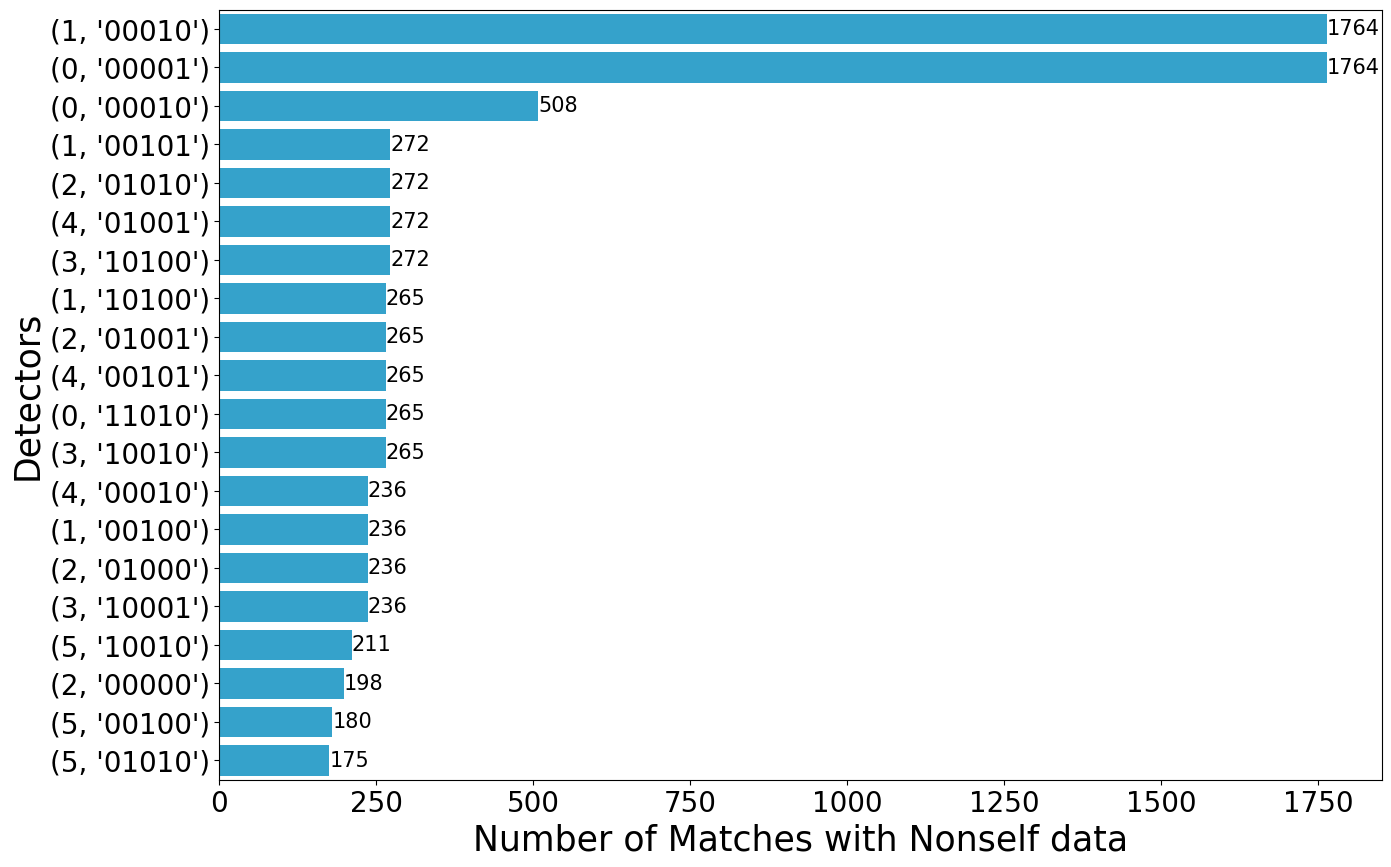

In [22]:
fig, axes = plt.subplots(figsize=(15,10))
bar = sns.barplot(x=match.matched.head(20), y=match.head(20).index, color="#1cade4", ax=axes)
plt.bar_label(bar.containers[0],fontsize=15)
bar.set_ylabel("Detectors",fontsize=25)
bar.set_xlabel("Number of Matches with Nonself data",fontsize=25)
bar.tick_params(labelsize=20)
# plt.title('Number of Matches by Detector')


# Detector Analysis

## 0, '00001'

In [23]:
det = (0, '00001')

In [24]:
res[res[det]]

,"(0, 00000)","(0, 01100)","(0, 11010)","(0, 01000)","(0, 00110)","(0, 11011)","(0, 10101)","(0, 01001)","(0, 10111)","(0, 10100)",...,"(7, 10101)","(7, 00110)","(7, 10000)","(7, 11111)","(7, 00011)","(7, 11110)","(7, 10110)","(7, 10011)","(7, 11010)","(7, 00101)"
24,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
40,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
57,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19951,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19968,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19977,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19978,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
df.reset_index().loc[(res[res[det]].index)].is_property_violation.value_counts()

1    1764
Name: is_property_violation, dtype: int64

Only matched property violations!

In [26]:
perc = df.loc[(res[res[det]].index)].is_property_violation.value_counts().values[0] / df.query('is_property_violation == 1').shape[0]
print(f"Matched with {round(perc, 3) * 100}% of nonselfs in dataset")

Matched with 58.599999999999994% of nonselfs in dataset


In [27]:
for val, col in zip(det[1], sig_cols[:ns.r]):
    print(val, col)

0 temperature_was_available_during_transfered
0 temperature_transfered
0 temperature_was_available_during_centralhub_temperature_processed
0 temperature_battery_became_unavailable_during_trace
1 temperature_context_became_unavailable_during_trace


## 1, '00010'

In [28]:
det = (1, '00010')	

In [29]:
df.loc[(res[res[det]].index)].is_property_violation.value_counts()

1    1764
Name: is_property_violation, dtype: int64

Only matched property violations!

In [30]:
perc = df.loc[(res[res[det]].index)].is_property_violation.value_counts().values[0] / df.query('is_property_violation == 1').shape[0]
print(f"Matched with {round(perc, 3) * 100}% of nonselfs in dataset")

Matched with 58.599999999999994% of nonselfs in dataset


In [31]:
for val, col in zip(det[1], sig_cols[det[0]:det[0] + ns.r]):
    print(val, col)

0 temperature_transfered
0 temperature_was_available_during_centralhub_temperature_processed
0 temperature_battery_became_unavailable_during_trace
1 temperature_context_became_unavailable_during_trace
0 temperature_battery_became_unavailable_during_processed


## 0, '00010'

In [32]:
det = (0, '00010')	

In [33]:
df.loc[(res[res[det]].index)].is_property_violation.value_counts()

1    508
Name: is_property_violation, dtype: int64

Only matched property violations!

In [34]:
perc = df.loc[(res[res[det]].index)].is_property_violation.value_counts().values[0] / df.query('is_property_violation == 1').shape[0]
print(f"Matched with {round(perc, 3) * 100}% of nonselfs in dataset")

Matched with 16.900000000000002% of nonselfs in dataset


In [35]:
for val, col in zip(det[1], sig_cols[det[0]:det[0] + ns.r]):
    print(val, col)

0 temperature_was_available_during_transfered
0 temperature_transfered
0 temperature_was_available_during_centralhub_temperature_processed
1 temperature_battery_became_unavailable_during_trace
0 temperature_context_became_unavailable_during_trace


## 2, '01010'

In [36]:
det = (2, '01010')	

In [37]:
df.loc[(res[res[det]].index)].is_property_violation.value_counts()

1    272
Name: is_property_violation, dtype: int64

Only matched property violations!

In [38]:
perc = df.loc[(res[res[det]].index)].is_property_violation.value_counts().values[0] / df.query('is_property_violation == 1').shape[0]
print(f"Matched with {round(perc, 3) * 100}% of nonselfs in dataset")

Matched with 9.0% of nonselfs in dataset


In [39]:
for val, col in zip(det[1], sig_cols[det[0]:det[0] + ns.r]):
    print(val, col)

0 temperature_was_available_during_centralhub_temperature_processed
1 temperature_battery_became_unavailable_during_trace
0 temperature_context_became_unavailable_during_trace
1 temperature_battery_became_unavailable_during_processed
0 temperature_battery_became_unavailable_during_transfered


In [40]:
for pos, chunk in match.index:
    print(f"Position: {pos}, Chunk: {chunk}")
    perc = df.loc[(res[res[(pos, chunk)]].index)].is_property_violation.value_counts().values[0] / df.query('is_property_violation == 1').shape[0]
    print(f"\tMatched with {round(perc * 100, 2)}% of nonselfs in dataset")
    print('\n')
    for val, col in zip(chunk, sig_cols[pos:pos + ns.r]):
        print(f"\t{val}, {col}")
    
    print('\n')

Position: 1, Chunk: 00010
	Matched with 58.57% of nonselfs in dataset


	0, temperature_transfered
	0, temperature_was_available_during_centralhub_temperature_processed
	0, temperature_battery_became_unavailable_during_trace
	1, temperature_context_became_unavailable_during_trace
	0, temperature_battery_became_unavailable_during_processed


Position: 0, Chunk: 00001
	Matched with 58.57% of nonselfs in dataset


	0, temperature_was_available_during_transfered
	0, temperature_transfered
	0, temperature_was_available_during_centralhub_temperature_processed
	0, temperature_battery_became_unavailable_during_trace
	1, temperature_context_became_unavailable_during_trace


Position: 0, Chunk: 00010
	Matched with 16.87% of nonselfs in dataset


	0, temperature_was_available_during_transfered
	0, temperature_transfered
	0, temperature_was_available_during_centralhub_temperature_processed
	1, temperature_battery_became_unavailable_during_trace
	0, temperature_context_became_unavailable_during_tra

# Errors

## False Negatives

In [41]:
df[(y_test == 1) & (y_pred == 0)]

,temperature_trace_no,temperature_collected_started,temperature_collected_finished,temperature_battery_became_unavailable_during_collected,temperature_battery_decrease_during_collected,temperature_processed,temperature_processed_started,temperature_processed_started_relative,temperature_processed_finished,temperature_processed_finished_relative,...,centralhub_battery_cell_soc_min,centralhub_detect_risk_max,centralhub_detect_risk_mean,centralhub_detect_risk_std,centralhub_detect_risk_min,centralhub_sig_emergency_max,is_property_violation,seed,temperature_observer_error_active_max,self_str
905,9.0,28.5,28.51,0,0.017772,1,29.270014,0.770014,29.280014,0.780014,...,0.755826,58.289090,58.289090,0.000000,58.289090,0.0,1,153,NaN,1100100011111
2354,0.0,3.5,3.51,0,0.023610,1,4.070714,0.570714,4.080714,0.580714,...,0.981085,0.000000,0.000000,0.000000,0.000000,0.0,1,239,NaN,1100100011111
2434,2.0,11.0,11.01,0,0.021361,1,11.489056,0.489056,11.499056,0.499056,...,0.940537,56.425331,40.551558,20.413161,14.319995,0.0,1,243,NaN,1100100011111
3299,7.0,21.0,21.01,0,0.010666,1,21.469564,0.469564,21.479564,0.479564,...,0.666292,60.565794,60.157303,0.487467,59.576016,1.0,1,294,NaN,1100100011111
5127,16.0,53.5,53.51,0,0.014475,1,53.920412,0.420412,53.930412,0.430412,...,0.910368,73.735224,73.698968,0.036350,73.662550,1.0,1,402,NaN,1100100011011
7171,13.0,38.5,38.51,0,0.017448,1,38.847786,0.347786,38.857786,0.357786,...,0.529341,56.965584,29.970823,14.102695,22.608615,0.0,1,522,NaN,1100100011111
7400,4.0,13.5,13.51,0,0.018808,1,13.964606,0.464606,13.974606,0.474606,...,0.788920,76.302091,64.713318,13.877382,48.107581,1.0,1,535,NaN,1100100011111
9474,10.0,33.5,33.51,0,0.024501,1,33.992966,0.492966,34.002966,0.502966,...,0.757165,54.623972,53.527616,0.656225,53.135121,0.0,1,646,NaN,1100100011111
9949,7.0,21.0,21.01,0,0.009171,1,21.504638,0.504638,21.514638,0.514638,...,0.698912,53.853832,48.279377,7.501440,38.192268,0.0,1,676,NaN,1100100011111
10269,8.0,46.0,46.01,0,0.017300,1,46.403343,0.403343,46.413344,0.413343,...,0.837487,55.009966,53.471058,1.692063,51.611957,0.0,1,692,NaN,1100100011111


For these violations, no pattern was found during training.

## False Positives

In [42]:
df[(y_test == 0) & (y_pred == 1)]

,temperature_trace_no,temperature_collected_started,temperature_collected_finished,temperature_battery_became_unavailable_during_collected,temperature_battery_decrease_during_collected,temperature_processed,temperature_processed_started,temperature_processed_started_relative,temperature_processed_finished,temperature_processed_finished_relative,...,centralhub_battery_cell_soc_min,centralhub_detect_risk_max,centralhub_detect_risk_mean,centralhub_detect_risk_std,centralhub_detect_risk_min,centralhub_sig_emergency_max,is_property_violation,seed,temperature_observer_error_active_max,self_str


No false positives means that the detectors matched only nonselfs.

# Coverage

In [43]:
match.matched

(1, 00010)    1764
(0, 00001)    1764
(0, 00010)     508
(1, 00101)     272
(2, 01010)     272
(4, 01001)     272
(3, 10100)     272
(1, 10100)     265
(2, 01001)     265
(4, 00101)     265
(0, 11010)     265
(3, 10010)     265
(4, 00010)     236
(1, 00100)     236
(2, 01000)     236
(3, 10001)     236
(5, 10010)     211
(2, 00000)     198
(5, 00100)     180
(5, 01010)     175
(0, 00011)     173
(5, 10011)     149
(5, 01011)     144
(5, 00101)     141
(6, 01000)     122
(0, 00000)     115
(1, 00000)     115
(6, 10100)     112
(6, 10111)     107
(7, 10000)      97
(6, 01011)      95
(2, 01110)      88
(1, 00111)      88
(4, 11001)      88
(3, 11100)      88
(2, 01100)      85
(3, 11001)      85
(1, 00110)      85
(4, 10010)      85
(0, 11000)      83
(1, 10000)      83
(7, 10111)      69
(6, 10101)      63
(6, 01001)      58
(3, 11010)      54
(4, 10101)      54
(2, 01101)      54
(1, 10110)      54
(0, 11011)      54
(6, 01010)      46
(6, 10110)      37
(7, 10010)      35
(7, 10101)  

## Detectors that did not match any data

In [44]:
total_matches = res.sum() 

In [45]:
zero_matches = total_matches[total_matches == 0]
print(f"{zero_matches.shape[0]} Nonself detectors did not match any data")
zero_matches

171 Nonself detectors did not match any data


(0, 01100)    0
(0, 01000)    0
(0, 00110)    0
(0, 10101)    0
(0, 10111)    0
             ..
(7, 11111)    0
(7, 00011)    0
(7, 11110)    0
(7, 11010)    0
(7, 00101)    0
Length: 171, dtype: int64

In [46]:
res.drop(zero_matches.index, axis = 1, inplace=True)

## Calculating minimal number of detectors

In [47]:
matched = (res
            .sum()
            .rename('matched')
            .sort_values(ascending=False)
            .to_frame()
        )
matched

,matched
"(1, 00010)",1764
"(0, 00001)",1764
"(0, 00010)",508
"(3, 10100)",272
"(2, 01010)",272
"(4, 01001)",272
"(1, 00101)",272
"(0, 11010)",265
"(2, 01001)",265
"(4, 00101)",265


In [48]:
calc_covg = res.copy()
coverage = pd.Series()
for det in matched.index:
    size = calc_covg[det].sum()
    coverage = pd.concat([coverage, pd.Series(size, index=[det])])
    calc_covg = calc_covg[calc_covg[det] != 1]

C:\Users\araujo\AppData\Local\Temp\ipykernel_2608\2642750642.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  coverage = pd.Series()


In [49]:
coverage

(1, 00010)    1764
(0, 00001)       0
(0, 00010)     508
(3, 10100)       0
(2, 01010)       0
(4, 01001)       0
(1, 00101)       0
(0, 11010)     265
(2, 01001)       0
(4, 00101)       0
(3, 10010)       0
(1, 10100)       0
(1, 00100)       0
(3, 10001)       0
(4, 00010)       0
(2, 01000)       0
(5, 10010)      55
(2, 00000)     198
(5, 00100)      42
(5, 01010)      33
(0, 00011)      76
(5, 10011)       0
(5, 01011)      21
(5, 00101)       0
(6, 01000)       0
(0, 00000)       0
(1, 00000)       0
(6, 10100)       0
(6, 10111)       0
(7, 10000)       0
(6, 01011)       0
(2, 01110)       0
(1, 00111)       0
(4, 11001)       0
(3, 11100)       0
(1, 00110)       0
(3, 11001)       0
(4, 10010)       0
(2, 01100)       0
(1, 10000)       0
(0, 11000)       0
(7, 10111)       0
(6, 10101)       0
(6, 01001)       0
(3, 11010)       0
(0, 11011)       0
(2, 01101)       0
(1, 10110)       0
(4, 10101)       0
(6, 01010)       0
(6, 10110)       0
(7, 10010)       0
(7, 10101)  

In [50]:
coverage = coverage[coverage > 0]

In [51]:
coverage.sort_values(ascending=False)

(1, 00010)    1764
(0, 00010)     508
(0, 11010)     265
(2, 00000)     198
(0, 00011)      76
(5, 10010)      55
(5, 00100)      42
(5, 01010)      33
(5, 01011)      21
(0, 01001)      20
dtype: int64

7 detectors cover all of the found property violation cases!

<Axes: >

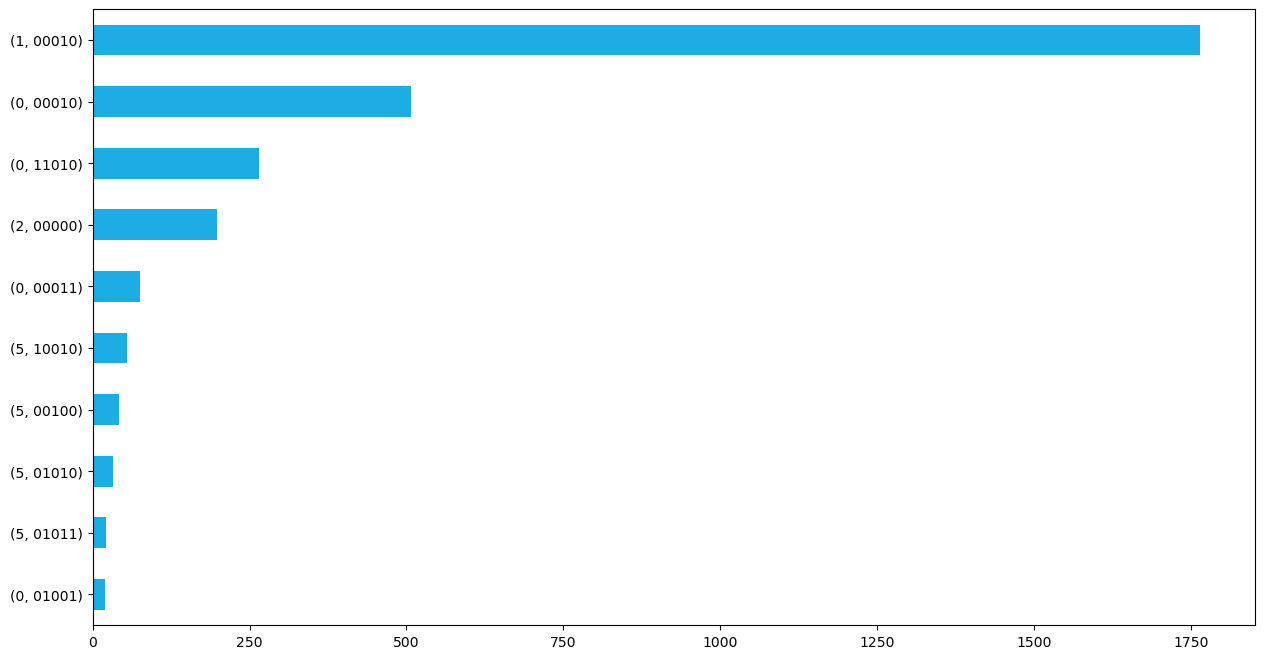

In [52]:
fig, axes = plt.subplots(figsize=(15,8))
coverage.sort_values().plot(kind='barh', color='#1cade4')

In [53]:
covg_cumulated_sum = (coverage / coverage.sum()).cumsum()
covg_cumulated_sum

(1, 00010)    0.591549
(0, 00010)    0.761905
(0, 11010)    0.850771
(5, 10010)    0.869215
(2, 00000)    0.935614
(5, 00100)    0.949698
(5, 01010)    0.960765
(0, 00011)    0.986251
(5, 01011)    0.993293
(0, 01001)    1.000000
dtype: float64

<Axes: >

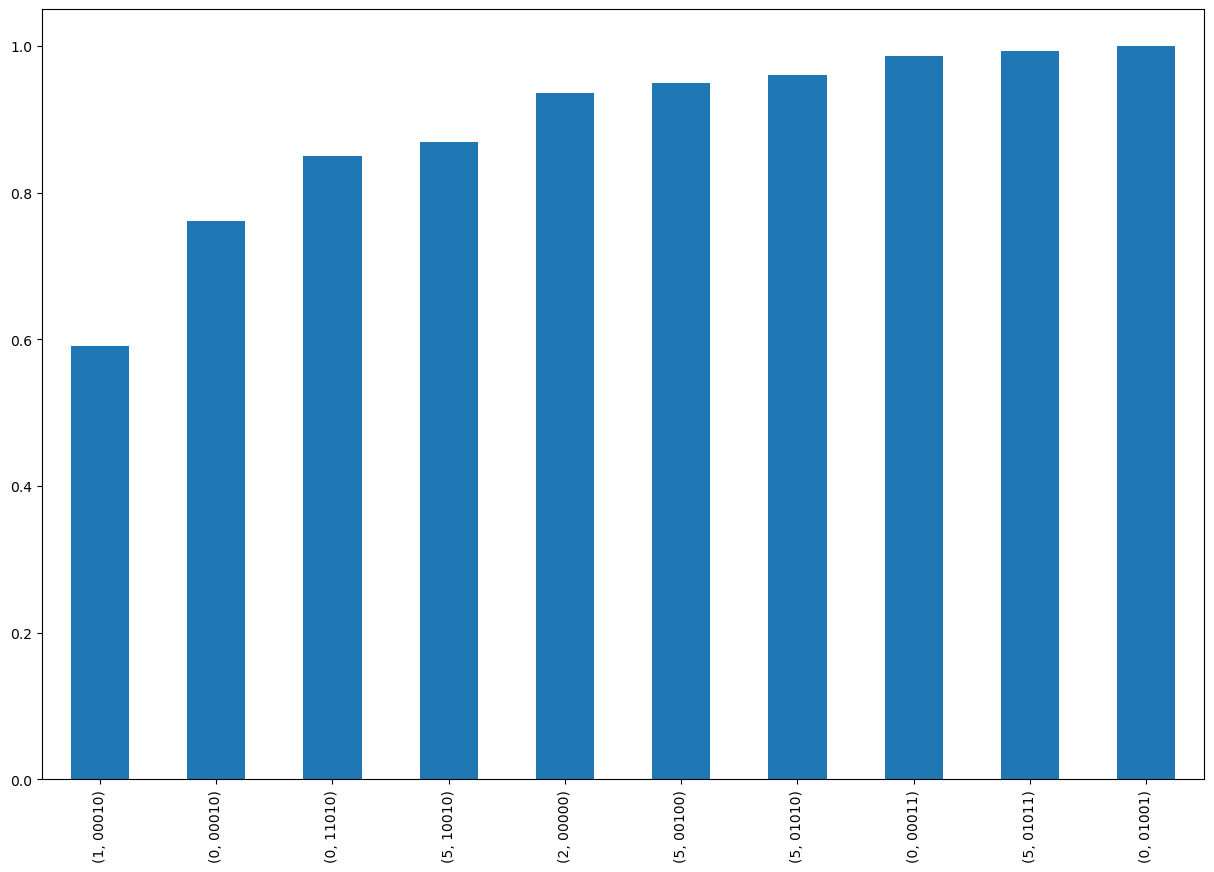

In [54]:
fig, axes = plt.subplots(figsize=(15,10))
covg_cumulated_sum.plot(kind='bar')

# Grouping Patterns

Patterns perfectly correlated are extended versions of the same pattern. Thus, they will be grouped together.

In [55]:
res = res.astype(int)

In [56]:
from sklearn.metrics import matthews_corrcoef

In [57]:
mt_corr = res.corr(method=matthews_corrcoef)

In [58]:
mt_corr

,"(0, 00000)","(0, 11010)","(0, 11011)","(0, 01001)","(0, 00011)","(0, 00001)","(0, 11000)","(0, 00010)","(1, 00110)","(1, 10100)",...,"(6, 10111)","(6, 01000)","(7, 10001)","(7, 10111)","(7, 10010)","(7, 10100)","(7, 10101)","(7, 10000)","(7, 10110)","(7, 10011)"
"(0, 00000)",1.000000,-0.008814,-0.003958,-0.002407,-0.007105,-0.023657,-0.004910,-0.012279,-0.004969,-0.008814,...,-0.005578,-0.005959,-0.002691,-0.004475,-0.003185,-0.002219,-0.002898,-0.005310,-0.002744,-0.002581
"(0, 11010)",-0.008814,1.000000,-0.006031,-0.003667,-0.010826,-0.036048,-0.007482,-0.018711,-0.007572,1.000000,...,0.536992,-0.009080,-0.004100,-0.006819,-0.004853,-0.003381,-0.004417,-0.008091,-0.004182,-0.003933
"(0, 11011)",-0.003958,-0.006031,1.000000,-0.001647,-0.004861,-0.016186,-0.003360,-0.008402,-0.003400,-0.006031,...,0.207524,-0.004077,-0.001841,-0.003062,-0.002179,-0.001518,-0.001983,-0.003633,-0.001878,-0.001766
"(0, 01001)",-0.002407,-0.003667,-0.001647,1.000000,-0.002956,-0.009842,-0.002043,-0.005109,-0.002067,-0.003667,...,-0.002321,-0.002479,-0.001120,-0.001862,-0.001325,-0.000923,-0.001206,-0.002209,-0.001142,-0.001074
"(0, 00011)",-0.007105,-0.010826,-0.004861,-0.002956,1.000000,-0.029058,-0.006031,-0.015083,0.699398,-0.010826,...,-0.006852,0.214583,0.088384,0.187882,0.073599,0.126970,0.138339,0.195550,0.071555,0.060555
"(0, 00001)",-0.023657,-0.036048,-0.016186,-0.009842,-0.029058,1.000000,-0.020082,-0.050220,-0.020323,-0.036048,...,-0.022815,-0.024371,-0.011005,-0.018304,-0.013025,-0.009073,-0.011854,-0.021717,-0.011224,-0.010555
"(0, 11000)",-0.004910,-0.007482,-0.003360,-0.002043,-0.006031,-0.020082,1.000000,-0.010424,-0.004218,-0.007482,...,-0.004735,-0.005058,-0.002284,-0.003799,-0.002703,-0.001883,-0.002460,-0.004508,-0.002330,-0.002191
"(0, 00010)",-0.012279,-0.018711,-0.008402,-0.005109,-0.015083,-0.050220,-0.010424,1.000000,-0.010549,-0.018711,...,-0.011842,0.354673,0.165176,0.250649,0.213735,0.104338,0.152528,0.313504,0.179387,0.172675
"(1, 00110)",-0.004969,-0.007572,-0.003400,-0.002067,0.699398,-0.020323,-0.004218,-0.010549,1.000000,-0.007572,...,-0.004792,0.310755,0.128206,0.271427,0.107599,0.182712,0.199501,0.283085,0.104298,0.088494
"(1, 10100)",-0.008814,1.000000,-0.006031,-0.003667,-0.010826,-0.036048,-0.007482,-0.018711,-0.007572,1.000000,...,0.536992,-0.009080,-0.004100,-0.006819,-0.004853,-0.003381,-0.004417,-0.008091,-0.004182,-0.003933


In [59]:
def concat_detectors(final_detector, detector, first_position):
    starting_bit = (len(final_detector[1]) + first_position) - detector[0]
    if starting_bit < 0:
        detector[1] = '.' * abs(starting_bit) + detector[1]
        starting_bit = 0
    new_det = final_detector[1] + detector[1][starting_bit:]
    return (first_position, new_det)

In [60]:
new_detector_set = list(mt_corr.columns)

for col in mt_corr:
    perfect = mt_corr[mt_corr[col] == 1][col]
    if len(perfect) == 0:
        continue
    # display(perfect)
    to_concat = list(perfect.index)
    to_concat.append(perfect.name)
    to_concat = list(pd.DataFrame(to_concat).sort_values(0).itertuples(index=False, name=None))

    new_detector = to_concat[0]
    if new_detector in new_detector_set:
        new_detector_set.remove(new_detector)
    for det in to_concat[1:]:
        new_detector = concat_detectors(new_detector, det, new_detector[0])
        if det in new_detector_set:
            new_detector_set.remove(det)
    new_detector_set.append(new_detector)
new_detector_set = pd.DataFrame(list(set(new_detector_set)), columns=['position','chunk'])
        

In [61]:
len(new_detector_set)

35

In [62]:
new_detector_set

,position,chunk
0,6,10111
1,6,01011
2,7,10011
3,0,00010
4,1,00101001
5,0,110100101
6,1,00111001
7,0,000010
8,5,00100
9,0,110000


### Predicting with new detectors

In [63]:
def match_single_str(nonself_str):
    for position in  new_detector_set.position.unique():
        for chunk in new_detector_set.query('position == @position').chunk.values:
            if chunk == nonself_str[position:len(chunk)]:
                return 1
    return 0

In [64]:
X_test = df.filter(sig_cols).fillna(0).assign(self_str = lambda x: signal2string(x))
y_pred = X_test.self_str.apply(match_single_str)

<Axes: >

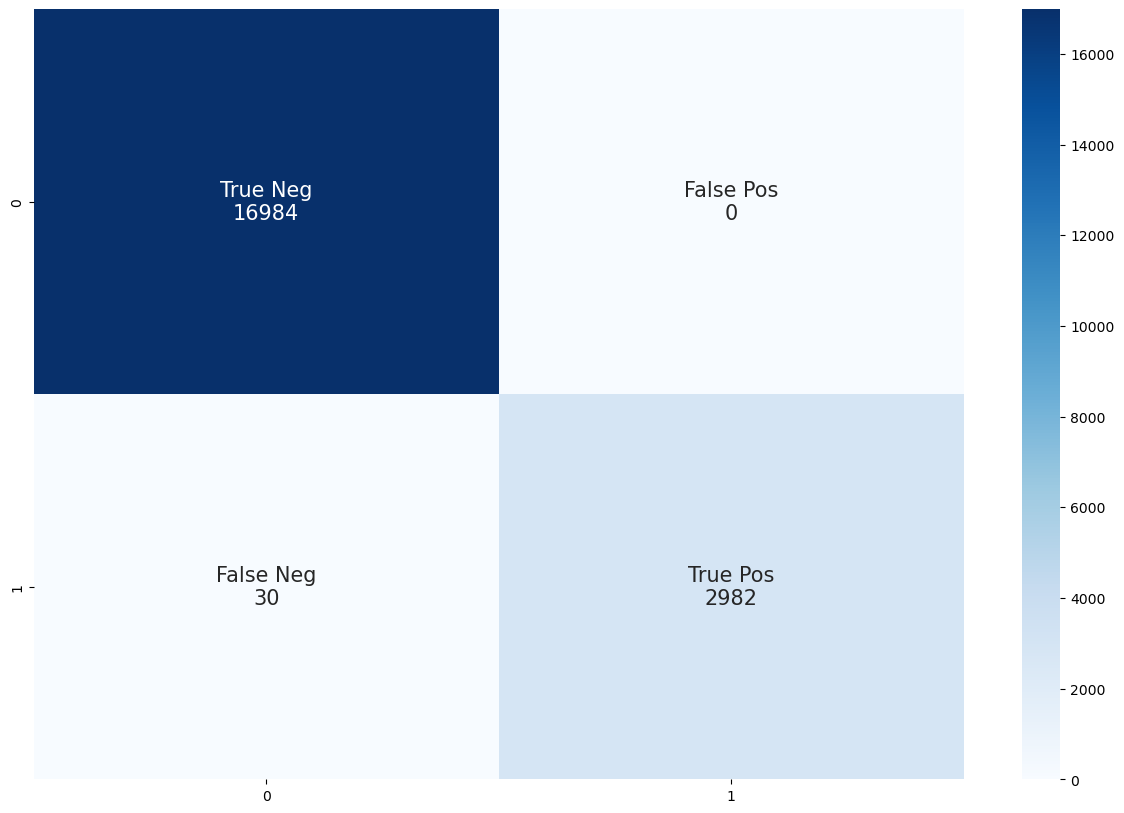

In [65]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [66]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16984
           1       1.00      0.99      0.99      3012

    accuracy                           1.00     19996
   macro avg       1.00      1.00      1.00     19996
weighted avg       1.00      1.00      1.00     19996



Same statistics! Nothing changed

In [67]:
res = pd.DataFrame(columns=new_detector_set.sort_values('position').values)
for pos, chunk in res.columns:
    res[(pos, chunk)] = df.self_str.str.slice(start=pos, stop=pos + len(chunk)) == chunk
res

,"(0, 110110101)","(0, 000000)","(0, 01001)","(0, 00010)","(0, 00011)","(0, 110100101)","(0, 110000)","(0, 000010)","(1, 00100010)","(1, 00111001)",...,"(6, 01010)","(6, 01011)","(7, 10010)","(7, 10110)","(7, 10100)","(7, 10101)","(7, 10000)","(7, 10011)","(7, 10111)","(7, 10001)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19992,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19993,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19994,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [68]:
matched = (res
        .sum()
        .rename('matched')
        .sort_values(ascending=False)
        .to_frame()
        # .assign(
        #     perc = lambda x: x / total,
        #     perc_cumsum = lambda x: x.perc.cumsum()
        # )
        # .query('matched > 0')
    )

In [69]:
matched

,matched
"(0, 000010)",1764
"(0, 00010)",508
"(1, 00101001)",272
"(0, 110100101)",265
"(1, 00100010)",236
"(5, 10010)",211
"(2, 00000)",198
"(5, 00100)",180
"(5, 01010)",175
"(0, 00011)",173


In [70]:
len(matched.query('matched > 0'))

35

### Coverage

In [71]:
calc_covg = res.copy()
coverage = pd.Series()
for det in matched.query('matched > 0').sort_values('matched', ascending=True).index:
    size = calc_covg[det].sum()
    coverage = pd.concat([coverage, pd.Series(size, index=[det])])
    calc_covg = calc_covg[calc_covg[det] != 1]

C:\Users\araujo\AppData\Local\Temp\ipykernel_2608\3997984413.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  coverage = pd.Series()


In [72]:
coverage

(7, 10100)          17
(0, 01001)          20
(7, 10011)          23
(7, 10001)          25
(7, 10110)          26
(7, 10101)          29
(7, 10010)          35
(6, 10110)          37
(6, 01010)           0
(0, 110110101)      49
(6, 01001)           0
(6, 10101)          54
(7, 10111)          69
(0, 110000)         83
(1, 00110010)       26
(1, 00111001)       88
(6, 01011)           0
(7, 10000)          71
(6, 10111)          91
(6, 10100)          88
(0, 000000)        115
(6, 01000)           0
(5, 00101)           0
(5, 01011)           0
(5, 10011)         116
(0, 00011)           0
(5, 01010)           0
(5, 00100)           0
(2, 00000)           0
(5, 10010)         156
(1, 00100010)        0
(0, 110100101)       0
(1, 00101001)        0
(0, 00010)           0
(0, 000010)       1764
dtype: int64

In [73]:
calc_covg = res.copy()
coverage = pd.Series()
for det in matched.query('matched > 0').sort_values('matched', ascending=False).index:
    size = calc_covg[det].sum()
    coverage = pd.concat([coverage, pd.Series(size, index=[det])])
    calc_covg = calc_covg[calc_covg[det] != 1]

C:\Users\araujo\AppData\Local\Temp\ipykernel_2608\2272499269.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  coverage = pd.Series()


In [74]:
coverage[coverage > 0]

(0, 000010)       1764
(0, 00010)         508
(0, 110100101)     265
(5, 10010)          55
(2, 00000)         198
(5, 00100)          42
(5, 01010)          33
(0, 00011)          76
(5, 01011)          21
(0, 01001)          20
dtype: int64

In [75]:
coverage[coverage > 0].sum()

2982

10 detectors cover all of the found property violation cases!

The coverage depends on the sorting

<Axes: >

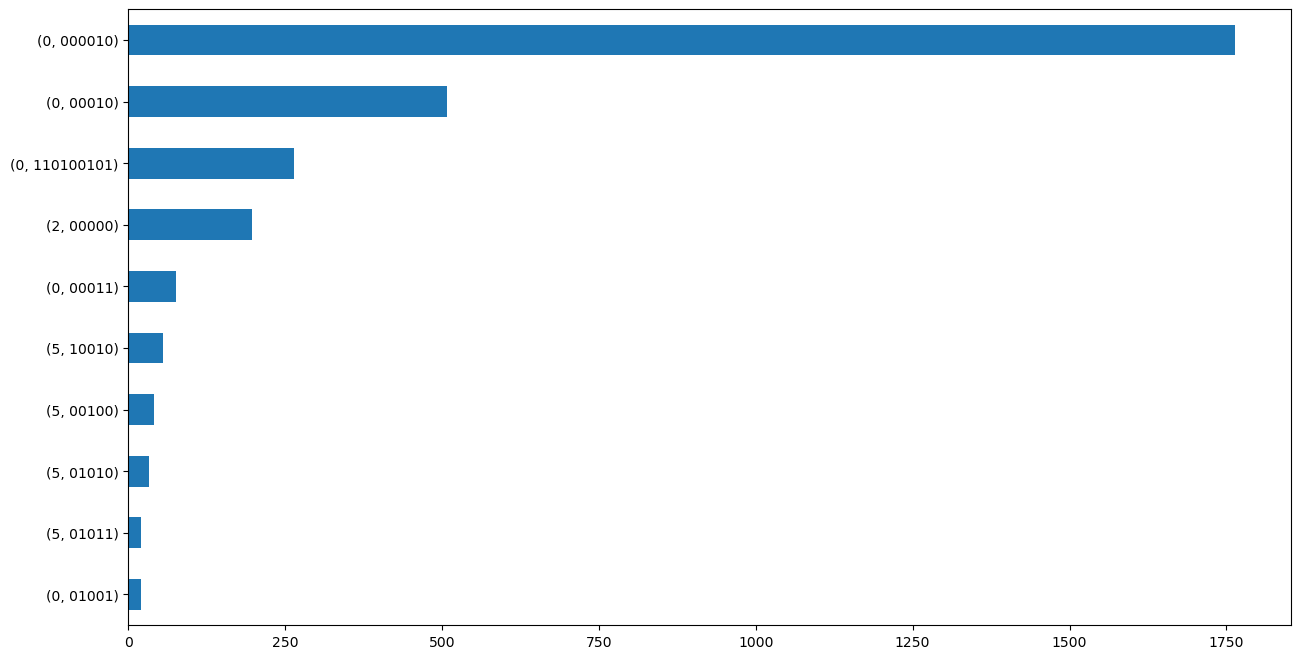

In [76]:
fig, axes = plt.subplots(figsize=(15,8))
coverage[coverage > 0].sort_values().plot(kind='barh')

In [77]:
covg_cumulated_sum = (coverage.sort_values(ascending=False) / coverage.sum()).cumsum()
covg_cumulated_sum

(0, 000010)       0.591549
(0, 00010)        0.761905
(0, 110100101)    0.850771
(2, 00000)        0.917170
(0, 00011)        0.942656
(5, 10010)        0.961100
(5, 00100)        0.975184
(5, 01010)        0.986251
(5, 01011)        0.993293
(0, 01001)        1.000000
(6, 10110)        1.000000
(6, 01001)        1.000000
(0, 110110101)    1.000000
(6, 01010)        1.000000
(7, 10001)        1.000000
(7, 10010)        1.000000
(7, 10101)        1.000000
(7, 10110)        1.000000
(7, 10111)        1.000000
(7, 10011)        1.000000
(6, 10101)        1.000000
(7, 10000)        1.000000
(0, 110000)       1.000000
(1, 00110010)     1.000000
(1, 00111001)     1.000000
(6, 01011)        1.000000
(6, 10111)        1.000000
(6, 10100)        1.000000
(0, 000000)       1.000000
(6, 01000)        1.000000
(5, 00101)        1.000000
(5, 10011)        1.000000
(1, 00100010)     1.000000
(1, 00101001)     1.000000
(7, 10100)        1.000000
dtype: float64

Text(0, 0.5, 'Percentage of Nonself')

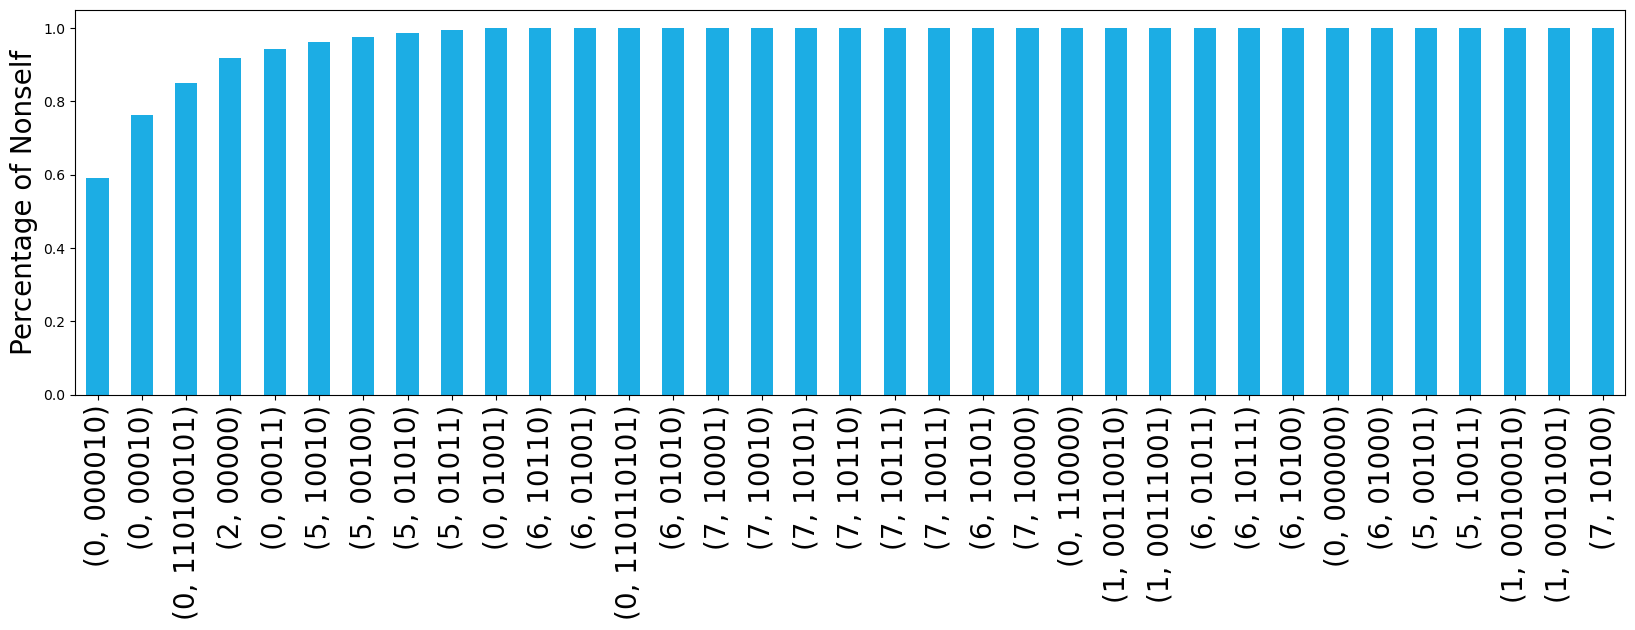

In [78]:
fig, axes = plt.subplots(figsize=(20,5))
covg_cumulated_sum.plot(kind='bar', color='#1cade4')

for label in (axes.get_xticklabels()):
	label.set_fontsize(20)

plt.ylabel('Percentage of Nonself', fontsize=20)

In [79]:
sig_cols


Index(['temperature_was_available_during_transfered', 'temperature_transfered',
       'temperature_was_available_during_centralhub_temperature_processed',
       'temperature_battery_became_unavailable_during_trace',
       'temperature_context_became_unavailable_during_trace',
       'temperature_battery_became_unavailable_during_processed',
       'temperature_battery_became_unavailable_during_transfered',
       'temperature_battery_became_unavailable_during_collected',
       'temperature_processed', 'abpd_sig_battery_on_min',
       'heartrate_sig_battery_on_min', 'oximeter_sig_battery_on_min',
       'abps_sig_battery_on_min'],
      dtype='object')

In [80]:
for det in coverage[coverage > 0].index:
    print(det)
    for val, col in zip(det[1], list(sig_cols)[det[0]:det[0] + len(det[1])]):
                print(f"\t{val}, {col}")
    print('\n\n')

(0, '000010')
	0, temperature_was_available_during_transfered
	0, temperature_transfered
	0, temperature_was_available_during_centralhub_temperature_processed
	0, temperature_battery_became_unavailable_during_trace
	1, temperature_context_became_unavailable_during_trace
	0, temperature_battery_became_unavailable_during_processed



(0, '00010')
	0, temperature_was_available_during_transfered
	0, temperature_transfered
	0, temperature_was_available_during_centralhub_temperature_processed
	1, temperature_battery_became_unavailable_during_trace
	0, temperature_context_became_unavailable_during_trace



(0, '110100101')
	1, temperature_was_available_during_transfered
	1, temperature_transfered
	0, temperature_was_available_during_centralhub_temperature_processed
	1, temperature_battery_became_unavailable_during_trace
	0, temperature_context_became_unavailable_during_trace
	0, temperature_battery_became_unavailable_during_processed
	1, temperature_battery_became_unavailable_during_transfere

# Correlation using recall

In [81]:
from sklearn.metrics import recall_score

In [82]:
det_set = list(matched.query('matched > 0').index)

In [83]:
recall_corr = pd.DataFrame(index=det_set)
for det1 in det_set:
    recall = list()
    for det2 in det_set:
        recall.append(recall_score(res[det1], res[det2]))
    recall_corr[det1] = recall


In [84]:
recall_corr

,"(0, 000010)","(0, 00010)","(1, 00101001)","(0, 110100101)","(1, 00100010)","(5, 10010)","(2, 00000)","(5, 00100)","(5, 01010)","(0, 00011)",...,"(0, 110110101)","(6, 01010)","(6, 10110)","(7, 10010)","(7, 10101)","(7, 10110)","(7, 10001)","(7, 10011)","(0, 01001)","(7, 10100)"
"(0, 000010)",1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000
"(0, 00010)",0.0,1.000000,1.000000,0.000000,1.000000,0.739336,0.000000,0.766667,0.000000,0.000000,...,0.000000,0.630435,0.000000,0.828571,0.655172,0.807692,0.76,0.826087,0.0,0.588235
"(1, 00101001)",0.0,0.535433,1.000000,0.000000,0.000000,0.739336,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000
"(0, 110100101)",0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.811429,0.000000,...,0.000000,0.000000,0.864865,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000
"(1, 00100010)",0.0,0.464567,0.000000,0.000000,1.000000,0.000000,0.000000,0.766667,0.000000,0.000000,...,0.000000,0.630435,0.000000,0.828571,0.655172,0.807692,0.76,0.826087,0.0,0.588235
"(5, 10010)",0.0,0.307087,0.573529,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.317919,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000
"(2, 00000)",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000
"(5, 00100)",0.0,0.271654,0.000000,0.000000,0.584746,0.000000,0.000000,1.000000,0.000000,0.242775,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00,1.000000,0.0,0.000000
"(5, 01010)",0.0,0.000000,0.000000,0.535849,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.611111,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000
"(0, 00011)",0.0,0.000000,0.000000,0.000000,0.000000,0.260664,0.000000,0.233333,0.000000,1.000000,...,0.000000,0.369565,0.000000,0.171429,0.344828,0.192308,0.24,0.173913,0.0,0.411765


In [85]:
repeated_matches = pd.DataFrame(index=det_set)
for det1 in det_set:
    repeated = list()
    for det2 in det_set:
        n_repeated = res.loc[(res[det1]) & (res[det2]), [det1]].sum().values[0]
        repeated.append(n_repeated)
    repeated_matches[det1] = repeated


In [86]:
repeated_matches.sort_index()

,"(0, 000010)","(0, 00010)","(1, 00101001)","(0, 110100101)","(1, 00100010)","(5, 10010)","(2, 00000)","(5, 00100)","(5, 01010)","(0, 00011)",...,"(0, 110110101)","(6, 01010)","(6, 10110)","(7, 10010)","(7, 10101)","(7, 10110)","(7, 10001)","(7, 10011)","(0, 01001)","(7, 10100)"
"(0, 000000)",0.0,0.0,0.0,0.0,0.0,0.0,115.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0, 000010)",1764.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0, 00010)",0.0,508.0,272.0,0.0,236.0,156.0,0.0,138.0,0.0,0.0,...,0.0,29.0,0.0,29.0,19.0,21.0,19.0,19.0,0.0,10.0
"(0, 00011)",0.0,0.0,0.0,0.0,0.0,55.0,0.0,42.0,0.0,173.0,...,0.0,17.0,0.0,6.0,10.0,5.0,6.0,4.0,0.0,7.0
"(0, 01001)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0
"(0, 110000)",0.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0, 110100101)",0.0,0.0,0.0,265.0,0.0,0.0,0.0,0.0,142.0,0.0,...,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(0, 110110101)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,...,54.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(1, 00100010)",0.0,236.0,0.0,0.0,236.0,0.0,0.0,138.0,0.0,0.0,...,0.0,29.0,0.0,29.0,19.0,21.0,19.0,19.0,0.0,10.0
"(1, 00101001)",0.0,272.0,272.0,0.0,0.0,156.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
matched = matched.sort_index()

In [88]:
only_important = [idx for idx in matched.index if idx[0] < 5]

In [89]:
only_important

[(0, '000000'),
 (0, '000010'),
 (0, '00010'),
 (0, '00011'),
 (0, '01001'),
 (0, '110000'),
 (0, '110100101'),
 (0, '110110101'),
 (1, '00100010'),
 (1, '00101001'),
 (1, '00110010'),
 (1, '00111001'),
 (2, '00000')]

In [138]:
(res[only_important].sum(axis=1)>0).sum() == coverage[coverage > 0].sum()

True

# Sankey

In [376]:
c = recall_corr[only_important][only_important].T

In [377]:
c

,"(0, 000010)","(0, 00010)","(1, 00101001)","(0, 110100101)","(1, 00100010)","(5, 10010)","(2, 00000)","(5, 00100)","(5, 01010)","(0, 00011)",...,"(0, 110110101)","(6, 01010)","(6, 10110)","(7, 10010)","(7, 10101)","(7, 10110)","(7, 10001)","(7, 10011)","(0, 01001)","(7, 10100)"
"(0, 000000)",0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"(0, 000010)",1.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"(0, 00010)",0.0,1.0,0.535433,0.0,0.464567,0.307087,0.0,0.271654,0.000000,0.0,...,0.0,0.057087,0.000000,0.057087,0.037402,0.041339,0.037402,0.037402,0.0,0.019685
"(0, 00011)",0.0,0.0,0.000000,0.0,0.000000,0.317919,0.0,0.242775,0.000000,1.0,...,0.0,0.098266,0.000000,0.034682,0.057803,0.028902,0.034682,0.023121,0.0,0.040462
"(0, 01001)",0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
"(0, 110000)",0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"(0, 110100101)",0.0,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.535849,0.0,...,0.0,0.000000,0.120755,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"(0, 110110101)",0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.611111,0.0,...,1.0,0.000000,0.092593,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
"(1, 00100010)",0.0,1.0,0.000000,0.0,1.000000,0.000000,0.0,0.584746,0.000000,0.0,...,0.0,0.122881,0.000000,0.122881,0.080508,0.088983,0.080508,0.080508,0.0,0.042373
"(1, 00101001)",0.0,1.0,1.000000,0.0,0.000000,0.573529,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [375]:
detector_set

{'Matched Non-self': 0,
 "(0, '000010')": 1,
 "(0, '00010')": 2,
 "(1, '00101001')": 3,
 "(0, '110100101')": 4,
 "(1, '00100010')": 5,
 "(5, '10010')": 6,
 "(2, '00000')": 7,
 "(5, '00100')": 8,
 "(5, '01010')": 9,
 "(0, '00011')": 10,
 "(5, '10011')": 11,
 "(5, '01011')": 12,
 "(5, '00101')": 13,
 "(6, '01000')": 14,
 "(0, '000000')": 15,
 "(6, '10100')": 16,
 "(6, '10111')": 17,
 "(7, '10000')": 18,
 "(6, '01011')": 19,
 "(1, '00111001')": 20,
 "(1, '00110010')": 21,
 "(0, '110000')": 22,
 "(7, '10111')": 23,
 "(6, '10101')": 24,
 "(6, '01001')": 25,
 "(0, '110110101')": 26,
 "(6, '01010')": 27,
 "(6, '10110')": 28,
 "(7, '10010')": 29,
 "(7, '10101')": 30,
 "(7, '10110')": 31,
 "(7, '10001')": 32,
 "(7, '10011')": 33,
 "(0, '01001')": 34,
 "(7, '10100')": 35}

In [378]:
detector_set = pd.DataFrame(["Matched Non-self"])
detector_set = pd.concat([detector_set, pd.DataFrame([str(col) for col in c.index])]).reset_index(drop=True).reset_index().set_index(0).to_dict()['index']
detector_set

{'Matched Non-self': 0,
 "(0, '000000')": 1,
 "(0, '000010')": 2,
 "(0, '00010')": 3,
 "(0, '00011')": 4,
 "(0, '01001')": 5,
 "(0, '110000')": 6,
 "(0, '110100101')": 7,
 "(0, '110110101')": 8,
 "(1, '00100010')": 9,
 "(1, '00101001')": 10,
 "(1, '00110010')": 11,
 "(1, '00111001')": 12,
 "(2, '00000')": 13}

In [394]:
sk = pd.DataFrame()

# index for the plotly chart
detector_set = pd.DataFrame(["Matched Non-self"])
detector_set = pd.concat([detector_set, pd.DataFrame([str(col) for col in c.index])]).reset_index(drop=True).reset_index().set_index(0).to_dict()['index']

# getting sankey connections
for det in c.columns:
    node = c[(c[det] == 1)&(~c.index.isin([det]))][det].copy()
    
    if node.shape[0] < 1:
        continue

    for row in node.items():
        weight = res[res[row[0]] == 1][det].shape[0]
        sk = pd.concat([sk, pd.DataFrame([str(det), str(row[0]), weight]).T])
    # break

sk.columns = ['origin','destiny','weight']

# appending singleton detectors
detectors = pd.Series([str(det) for det in c.index])
singleton = detectors[~detectors.isin(sk.origin) & ~detectors.isin(sk.destiny)] 

for det in singleton.values:
    weight  = res[res[eval(det)]].shape[0]
    sk = pd.concat([sk, pd.DataFrame([str(det), str(det), weight], ['origin','destiny','weight']).T])


sk.reset_index(drop=True, inplace=True)

# setting indexes
sk['origin_idx'] = sk.origin.map(lambda x: detector_set[x] )
sk['destiny_idx'] = sk.destiny.map(lambda x: detector_set[x] )

# removing redundant connections
# sk = sk.drop([5,7,8,9,17,19,20,21])

In [395]:
sk.loc[sk.origin == sk.destiny, 'origin'] = 'Matched Non-self'
sk.loc[sk.origin_idx == sk.destiny_idx, 'origin_idx'] = 0

In [396]:
source = pd.DataFrame([
        ['Matched Non-self', "(0, '00010')", 508, 0, 3],
        ['Matched Non-self', "(2, '00000')", 198, 0, 13],
        ['Matched Non-self', "(0, '00011')", 173, 0, 4],
    ], 
    columns = ['origin','destiny','weight', "origin_idx","destiny_idx"])
sk = pd.concat([sk, source]).reset_index(drop=True)

In [421]:
sk

,origin,destiny,weight,origin_idx,destiny_idx
0,"(0, '00010')","(1, '00100010')",236,3,9
1,"(0, '00010')","(1, '00101001')",272,3,10
2,"(2, '00000')","(0, '000000')",115,13,1
3,"(2, '00000')","(0, '110000')",83,13,6
4,"(0, '00011')","(1, '00110010')",85,4,11
5,"(0, '00011')","(1, '00111001')",88,4,12
6,Matched Non-self,"(0, '000010')",1764,0,2
7,Matched Non-self,"(0, '01001')",20,0,5
8,Matched Non-self,"(0, '110100101')",265,0,7
9,Matched Non-self,"(0, '110110101')",54,0,8


In [418]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 50,
      # line = dict(color = "black", width = 0.5),
      label = list(detector_set.keys()),
    #   color = "rgba(28,173,228,255)"
      color=[
        'rgb(180, 193, 198)', 
        'rgb(141, 188, 157)',
        'rgb(207, 61, 78)', 
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)', 
        'rgb(207, 61, 78)',
        'rgb(141, 188, 157)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(141, 188, 157)',
        ]
    ),
    link = dict(
      source = sk.origin_idx.values, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = sk.destiny_idx.values,
      value = sk.weight.values,
      color=[
        'rgb(229, 241, 246)', 
        'rgb(229, 241, 246)',
        'rgb(235, 241, 237)', 
        'rgb(235, 241, 237)',
        'rgb(229, 241, 246)', 
        'rgb(229, 241, 246)',
        'rgb(246, 238, 239)',
        'rgb(246, 238, 239)',
        'rgb(229, 241, 246)',
        'rgb(229, 241, 246)',
        'rgb(229, 241, 246)',
        'rgb(235, 241, 237)',
        'rgb(229, 241, 246)',
        ]
  ))])

# fig.update_layout(title_text="Sankey Diagram", font_size=15)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1500,
    margin=dict(
        # l=50,
        r=200,
    ),
    font_size=25,
    # paper_bgcolor="LightSteelBlue",
)
fig.show()

In [420]:
import plotly.graph_objects as go


fig = go.Figure(data=[go.Sankey(
    textfont=dict(color="rgba(0,0,0,0)", size=1),
    node = dict(
      pad = 50,
      thickness = 50,
      # line = dict(color = "black", width = 0.5),
      label = list(detector_set.keys()),
    #   color = "rgba(28,173,228,255)"
      color=[
        'rgb(180, 193, 198)', 
        'rgb(141, 188, 157)',
        'rgb(207, 61, 78)', 
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)', 
        'rgb(207, 61, 78)',
        'rgb(141, 188, 157)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(26, 165, 218)',
        'rgb(141, 188, 157)',
        ]
    ),
    link = dict(
      source = sk.origin_idx.values, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = sk.destiny_idx.values,
      value = sk.weight.values,
      color=[
        'rgb(229, 241, 246)', 
        'rgb(229, 241, 246)',
        'rgb(235, 241, 237)', 
        'rgb(235, 241, 237)',
        'rgb(229, 241, 246)', 
        'rgb(229, 241, 246)',
        'rgb(246, 238, 239)',
        'rgb(246, 238, 239)',
        'rgb(229, 241, 246)',
        'rgb(229, 241, 246)',
        'rgb(229, 241, 246)',
        'rgb(235, 241, 237)',
        'rgb(229, 241, 246)',
        ]
  ))])

# fig.update_layout(title_text="Sankey Diagram", font_size=15)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1500,
    margin=dict(
        # l=50,
        r=200,
    ),
    font_size=25,
    # paper_bgcolor="LightSteelBlue",
)
fig.show()

# Percentage of Matches

In [94]:
origin = sk[~sk.origin.str.contains('5|6|7')].origin.map(eval)
destiny = sk[~sk.destiny.str.contains('5|6|7')].destiny.map(eval)
final_det = pd.concat([origin, destiny]).drop_duplicates().reset_index(drop=True)
final_det

0         (0, 00010)
1         (2, 00000)
2         (0, 00011)
3        (0, 000010)
4     (0, 110100101)
5     (0, 110110101)
6         (0, 01001)
7      (1, 00101001)
8      (1, 00100010)
9        (0, 000000)
10       (0, 110000)
11     (1, 00111001)
12     (1, 00110010)
dtype: object

In [95]:
calc_covg = res.copy()
coverage = pd.Series()
for det in final_det:
    size = calc_covg[det].sum()
    coverage = pd.concat([coverage, pd.Series(size, index=[det])])
    calc_covg = calc_covg[calc_covg[det] != 1]

C:\Users\araujo\AppData\Local\Temp\ipykernel_18128\2605556922.py:2: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [102]:
(coverage / coverage.sum()).sort_values(ascending=False) * 100

(0, 000010)       59.154930
(0, 00010)        17.035547
(0, 110100101)     8.886653
(2, 00000)         6.639839
(0, 00011)         5.801476
(0, 110110101)     1.810865
(0, 01001)         0.670691
(1, 00101001)      0.000000
(1, 00100010)      0.000000
(0, 000000)        0.000000
(0, 110000)        0.000000
(1, 00111001)      0.000000
(1, 00110010)      0.000000
dtype: float64

In [98]:
for det in final_det:
    print(det, res[det].sum())

(0, '00010') 508
(2, '00000') 198
(0, '00011') 173
(0, '000010') 1764
(0, '110100101') 265
(0, '110110101') 54
(0, '01001') 20
(1, '00101001') 272
(1, '00100010') 236
(0, '000000') 115
(0, '110000') 83
(1, '00111001') 88
(1, '00110010') 85


# Comparison

In [92]:
train = pd.read_parquet(os.path.join(WRANGLE_PATH, f'{SENSOR}_train_fxd.parquet'))
test = pd.read_parquet(os.path.join(WRANGLE_PATH, f'{SENSOR}_test_fxd.parquet'))

In [93]:
X_train = train.filter(sig_cols).fillna(0).astype(int)
y_train = train.is_property_violation

In [94]:
X_test = test.filter(sig_cols).fillna(0).astype(int)
y_test = test.is_property_violation

## Random Forest

In [95]:
y_train.value_counts()

0    12749
1     2223
Name: is_property_violation, dtype: int64

In [96]:
y_train.shape

(14972,)

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [98]:
# Make predictions for the test set
y_pred_test = forest.predict(X_test.filter(sig_cols).fillna(0))

<Axes: >

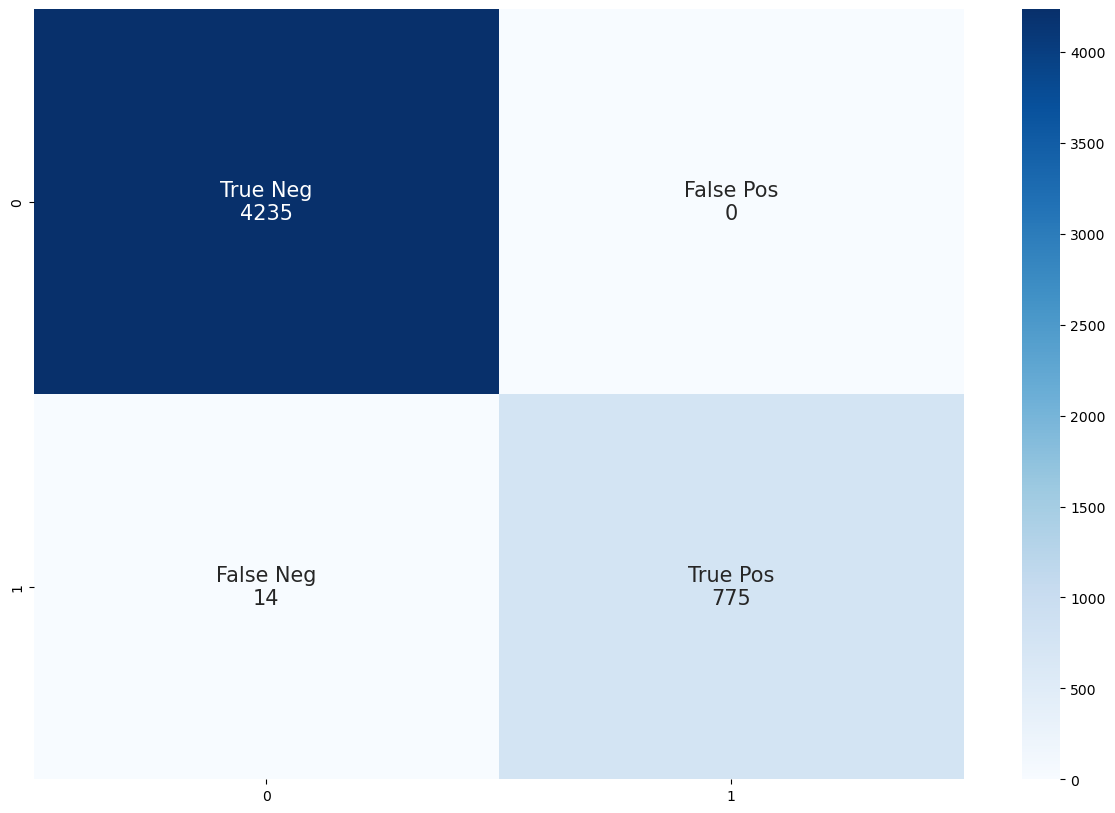

In [99]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred_test)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [100]:
print(classification_report(y_test, y_pred_test, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       1.00      0.98      0.99       789

    accuracy                           1.00      5024
   macro avg       1.00      0.99      0.99      5024
weighted avg       1.00      1.00      1.00      5024



In [101]:
recall_score(y_test, y_pred_test)

0.982256020278834

In [102]:
precision_score(y_test, y_pred_test)

1.0

In [103]:
accuracy_score(y_test, y_pred_test)

0.9972133757961783

In [104]:
matthews_corrcoef(y_test, y_pred_test)

0.9894541888717933

## One Class SVM

In [105]:
from sklearn.svm import OneClassSVM

In [106]:
clf = OneClassSVM().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [107]:
y_pred = pd.Series(y_pred).map({1: '0', -1: '1'}).astype(int)

<Axes: >

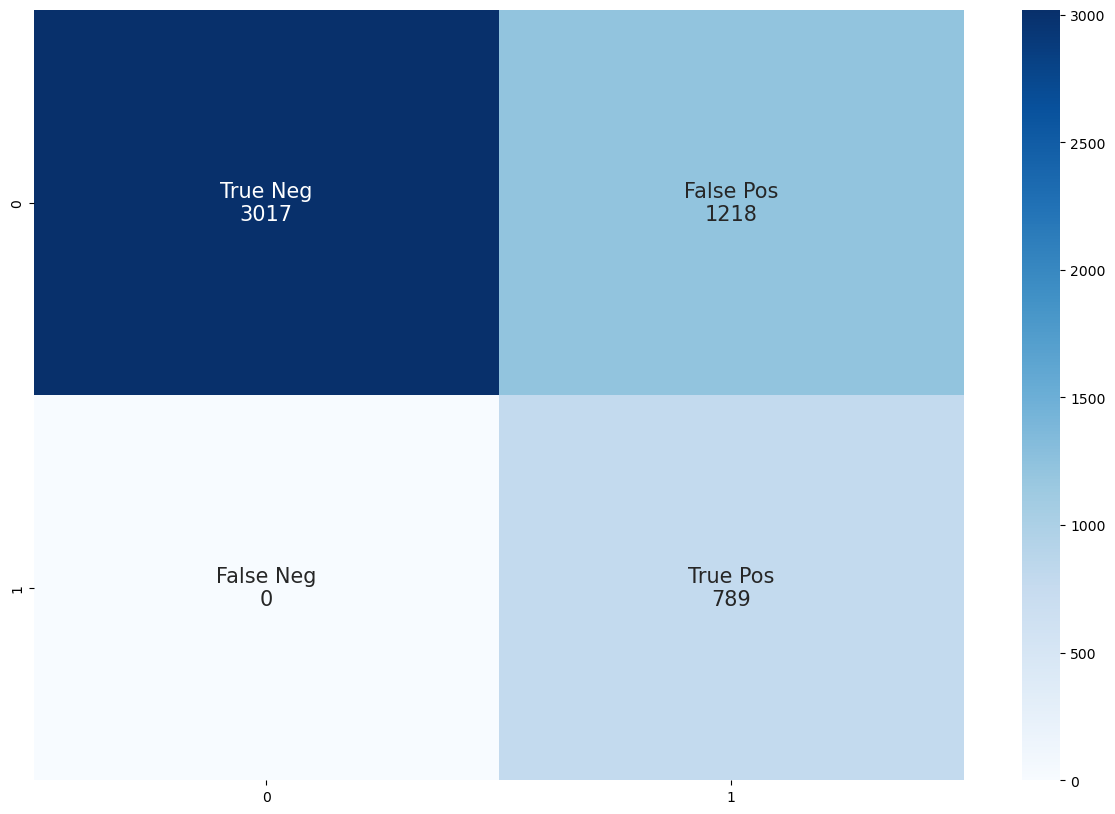

In [108]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [109]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83      4235
           1       0.39      1.00      0.56       789

    accuracy                           0.76      5024
   macro avg       0.70      0.86      0.70      5024
weighted avg       0.90      0.76      0.79      5024



In [110]:
recall_score(y_test, y_pred)

1.0

In [111]:
precision_score(y_test, y_pred)

0.3931240657698057

In [112]:
accuracy_score(y_test, y_pred)

0.7575636942675159

In [113]:
matthews_corrcoef(y_test, y_pred)

0.5292072229956061

## Gradient Boosting Classifier

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

In [115]:
clf = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [116]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

<Axes: >

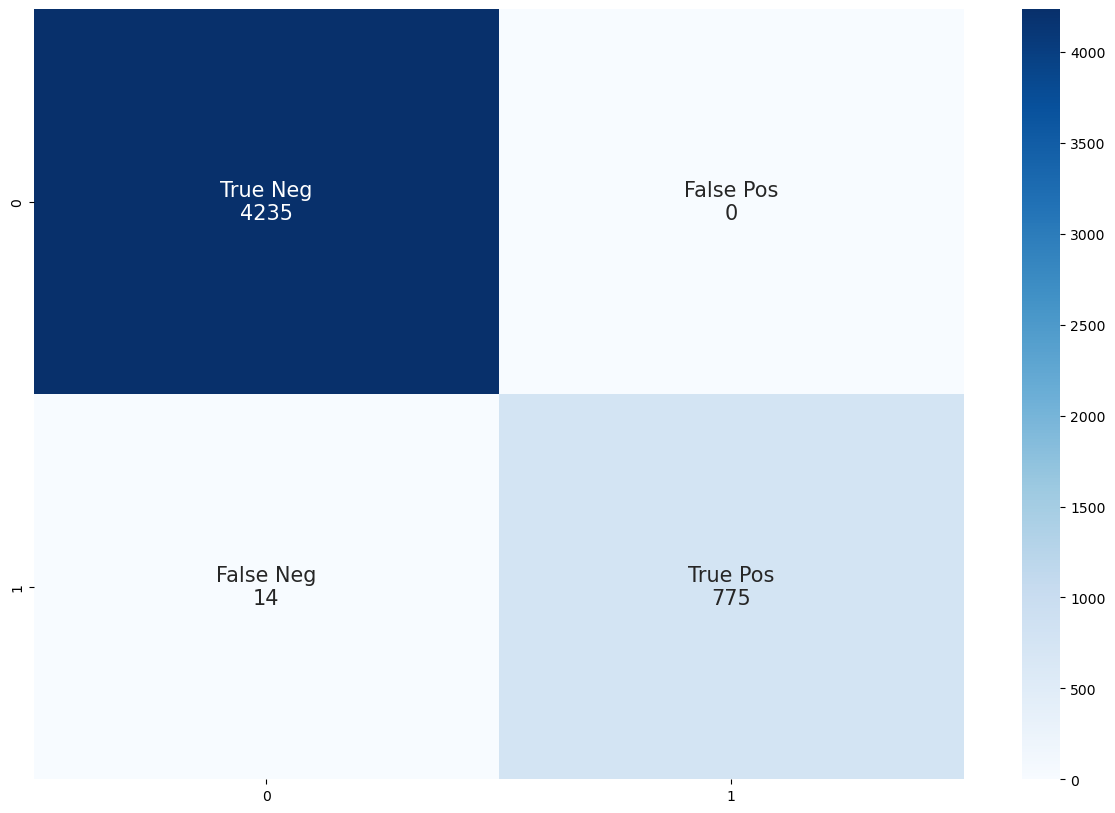

In [117]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [118]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       1.00      0.98      0.99       789

    accuracy                           1.00      5024
   macro avg       1.00      0.99      0.99      5024
weighted avg       1.00      1.00      1.00      5024



In [119]:
recall_score(y_test, y_pred)

0.982256020278834

In [120]:
precision_score(y_test, y_pred)

1.0

In [121]:
accuracy_score(y_test, y_pred)

0.9972133757961783

In [122]:
matthews_corrcoef(y_test, y_pred)

0.9894541888717933

## Isolation Forest

In [123]:
from sklearn.ensemble import IsolationForest

In [124]:
clf = IsolationForest().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [125]:
y_pred = pd.Series(y_pred).map({1: '0', -1: '1'}).astype(int)

In [126]:
y_pred

0       0
1       0
2       0
3       0
4       0
       ..
5019    0
5020    0
5021    0
5022    0
5023    1
Length: 5024, dtype: int32

<Axes: >

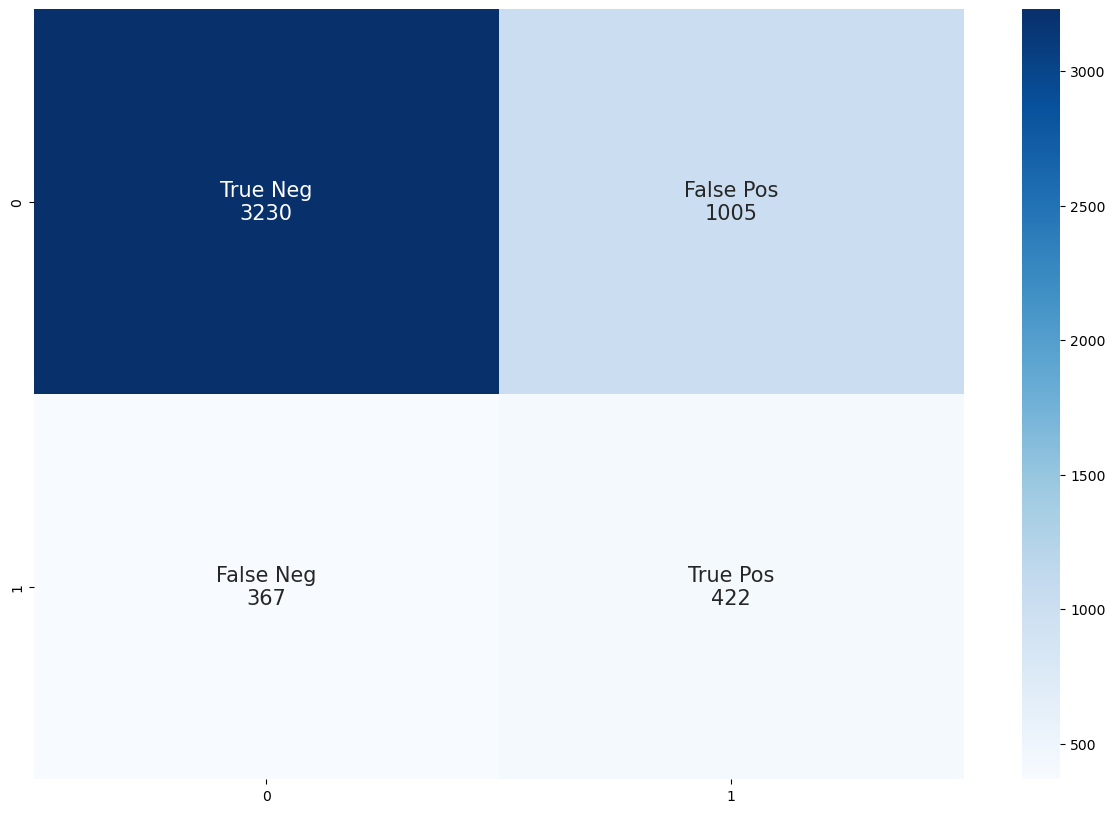

In [127]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [128]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.76      0.82      4235
           1       0.30      0.53      0.38       789

    accuracy                           0.73      5024
   macro avg       0.60      0.65      0.60      5024
weighted avg       0.80      0.73      0.76      5024



In [129]:
recall_score(y_test, y_pred)

0.5348542458808618

In [130]:
precision_score(y_test, y_pred)

0.29572529782761037

In [131]:
accuracy_score(y_test, y_pred)

0.7269108280254777

In [132]:
matthews_corrcoef(y_test, y_pred)

0.24006965312794545

## Negative Selection

In [133]:
ns = RChunkNSA(r=5, n_detectors=1000, alphabet=['0','1'])
ns.fit(X_train, y_train)

In [134]:
y_pred_ns = ns.predict(X_test)

<Axes: >

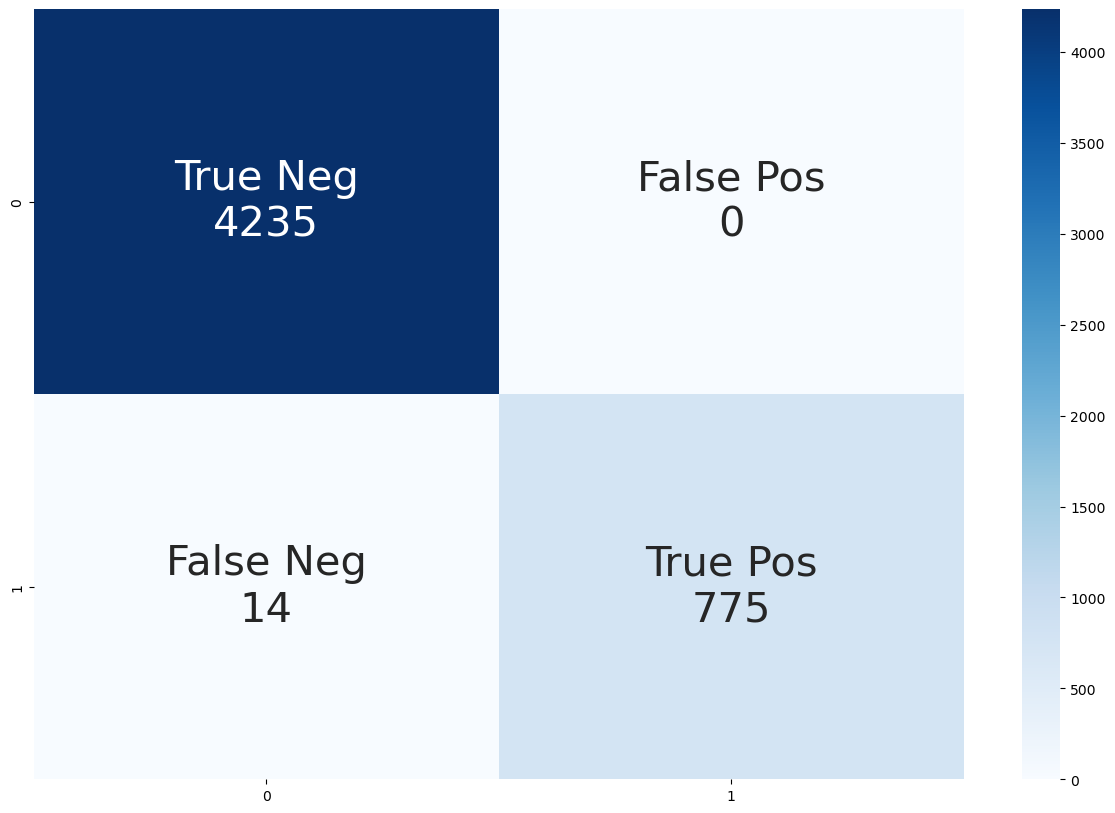

In [135]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred_ns)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":30})

In [136]:
print(classification_report(y_test, y_pred_ns, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       1.00      0.98      0.99       789

    accuracy                           1.00      5024
   macro avg       1.00      0.99      0.99      5024
weighted avg       1.00      1.00      1.00      5024



In [137]:
recall_score(y_test, y_pred_ns)

0.982256020278834

In [138]:
precision_score(y_test, y_pred_ns)

1.0

In [139]:
accuracy_score(y_test, y_pred_ns)

0.9972133757961783

In [140]:
matthews_corrcoef(y_test, y_pred_ns)

0.9894541888717933

# Comparison Against Another Surrogate Post-Model Method

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [142]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt = clf.predict(X_test)

<Axes: >

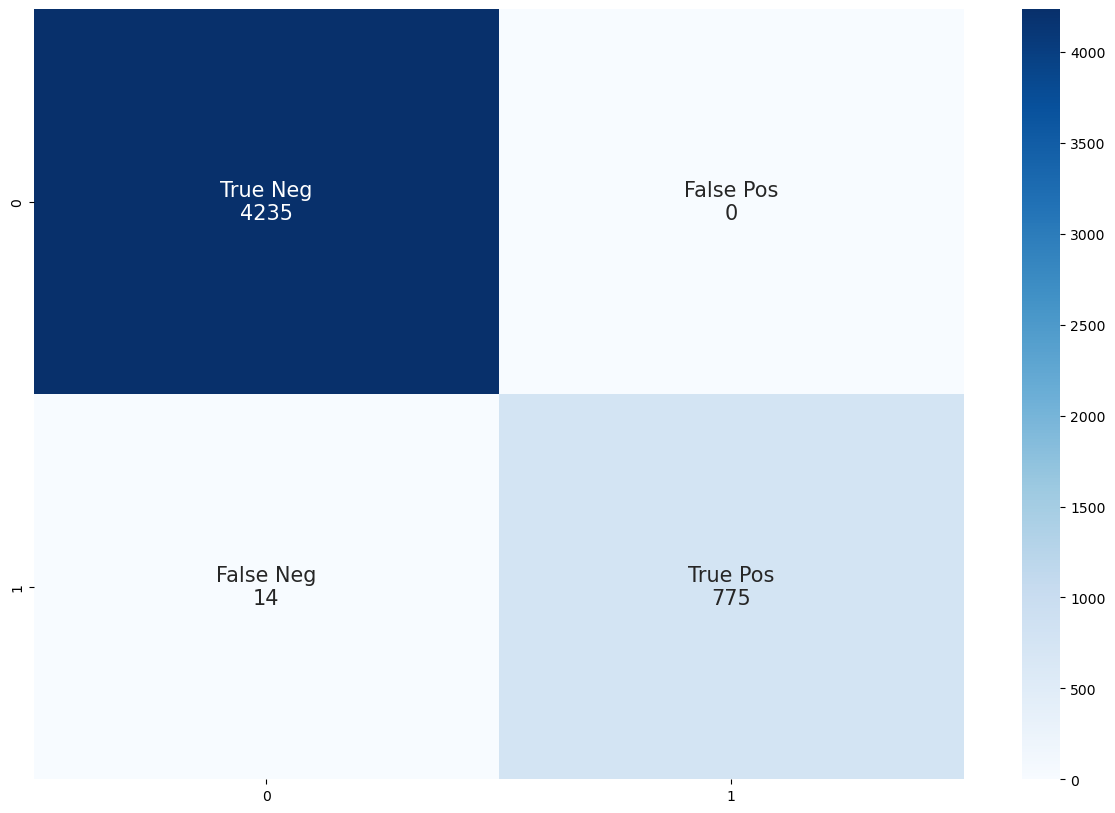

In [149]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred_dt)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [152]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       1.00      0.98      0.99       789

    accuracy                           1.00      5024
   macro avg       1.00      0.99      0.99      5024
weighted avg       1.00      1.00      1.00      5024



In [153]:
recall_score(y_test, y_pred_dt)

0.982256020278834

In [154]:
precision_score(y_test, y_pred_dt)

1.0

In [155]:
accuracy_score(y_test, y_pred_dt)

0.9972133757961783

In [156]:
matthews_corrcoef(y_test, y_pred_dt)

0.9894541888717933

In [158]:
X_train.columns

Index(['temperature_was_available_during_transfered', 'temperature_transfered',
       'temperature_was_available_during_centralhub_temperature_processed',
       'temperature_battery_became_unavailable_during_trace',
       'temperature_context_became_unavailable_during_trace',
       'temperature_battery_became_unavailable_during_processed',
       'temperature_battery_became_unavailable_during_transfered',
       'temperature_battery_became_unavailable_during_collected',
       'temperature_processed', 'abpd_sig_battery_on_min',
       'heartrate_sig_battery_on_min', 'oximeter_sig_battery_on_min',
       'abps_sig_battery_on_min'],
      dtype='object')

In [159]:
text_representation = tree.export_text(clf, feature_names=list(X_train.columns))
print(text_representation)

|--- temperature_was_available_during_transfered <= 0.50
|   |--- class: 1
|--- temperature_was_available_during_transfered >  0.50
|   |--- temperature_battery_became_unavailable_during_transfered <= 0.50
|   |   |--- temperature_was_available_during_centralhub_temperature_processed <= 0.50
|   |   |   |--- temperature_context_became_unavailable_during_trace <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- temperature_context_became_unavailable_during_trace >  0.50
|   |   |   |   |--- oximeter_sig_battery_on_min <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- oximeter_sig_battery_on_min >  0.50
|   |   |   |   |   |--- abps_sig_battery_on_min <= 0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- abps_sig_battery_on_min >  0.50
|   |   |   |   |   |   |--- heartrate_sig_battery_on_min <= 0.50
|   |   |   |   |   |   |   |--- abpd_sig_battery_on_min <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- abpd_sig_batt